# 🎯 Student Risk Prediction (Classification + Deployment Ready)
Predict whether students are at risk of underperforming (score < 60) using ML classification models. Includes preprocessing, model training, evaluation, visualizations, and deployment prep.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 316.6 kB/s eta 0:07:53
   ---------------------------------------- 0.5/150.0 MB 316.6 kB/s eta 0:07:53
   ---------------------------------------- 0.5/150.0 MB 316.6 kB/s eta 0:07:53
   ---------------------------------------- 0.5/150.0 MB 316.6 kB/s eta 0:07:53
   ---------------------------------------

In [2]:
data_path = os.path.join('..', 'data', 'exams.csv')
df = pd.read_csv(data_path)
df['avg_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)
df['at_risk'] = (df['avg_score'] < 60).astype(int)  # 1 = at risk
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,avg_score,at_risk
0,female,group D,some college,standard,completed,59,70,78,69.000000,0
1,male,group D,associate's degree,standard,none,96,93,87,92.000000,0
2,female,group D,some college,free/reduced,none,57,76,77,70.000000,0
3,male,group B,some college,free/reduced,none,70,70,63,67.666667,0
4,female,group D,associate's degree,standard,none,83,85,86,84.666667,0


In [3]:
ordinal_cols = ['parental level of education', 'lunch', 'test preparation course']
categories = [['some college','some high school', 'high school', "associate's degree", "bachelor's degree", "master's degree"],
             ['free/reduced', 'standard'],
             ['none', 'completed']]
enc_ord = OrdinalEncoder(categories=categories)
df[ordinal_cols] = enc_ord.fit_transform(df[ordinal_cols])

enc_oh = OneHotEncoder(sparse_output=False)
encoded = enc_oh.fit_transform(df[['gender', 'race/ethnicity']])
df[enc_oh.get_feature_names_out()] = encoded
df.drop(columns=['gender', 'race/ethnicity', 'math score', 'reading score', 'writing score', 'avg_score'], inplace=True)

In [4]:
X = df.drop('at_risk', axis=1)
y = df['at_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    results[name] = {'Accuracy': acc, 'F1 Score': f1}

pd.DataFrame(results).T.sort_values('F1 Score', ascending=False)

,Accuracy,F1 Score
KNN,0.745,0.281690
XGBoost,0.715,0.240000
Logistic Regression,0.780,0.214286
Random Forest,0.745,0.190476
Decision Tree,0.750,0.137931


In [6]:
best_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[134  26]
 [ 31   9]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       160
           1       0.26      0.23      0.24        40

    accuracy                           0.71       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.70      0.71      0.71       200



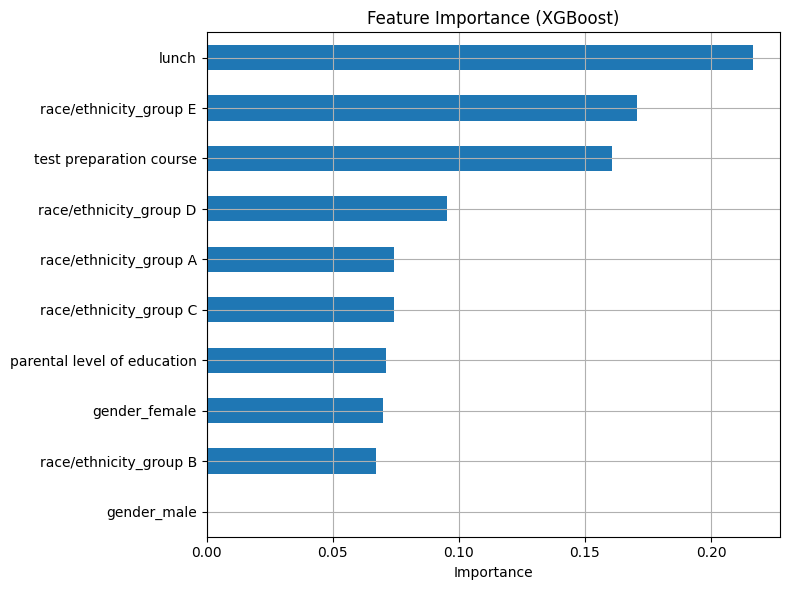

In [7]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.grid(True)
plt.show()